In [2]:
import torch
import torch.nn as nn
import torch.functional as F
import copy
import numpy as np
import math

/home/liumin/anaconda3/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EncoderDecoder(nn.Module):
	"""
	标准的Encoder-Decoder架构。这是很多模型的基础
	"""
	def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
		super(EncoderDecoder, self).__init__()
		# encoder和decoder都是构造的时候传入的，这样会非常灵活
		self.encoder = encoder
		self.decoder = decoder
		# 源语言和目标语言的embedding
		self.src_embed = src_embed
		self.tgt_embed = tgt_embed
		# generator后面会讲到，就是根据Decoder的隐状态输出当前时刻的词
		# 基本的实现就是隐状态输入一个全连接层，全连接层的输出大小是词的个数
		# 然后接一个softmax变成概率。
		self.generator = generator
	
	def forward(self, src, tgt, src_mask, tgt_mask):
		# 首先调用encode方法对输入进行编码，然后调用decode方法解码
		return self.decode(self.encode(src, src_mask), src_mask,
			tgt, tgt_mask)
	
	def encode(self, src, src_mask):
		# 调用encoder来进行编码，传入的参数embedding的src和src_mask
		return self.encoder(self.src_embed(src), src_mask)
	
	def decode(self, memory, src_mask, tgt, tgt_mask):
		# 调用decoder
		return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

EncoderDecoder定义了一种通用的Encoder-Decoder架构，具体的Encoder、Decoder、src_embed、target_embed和generator都是构造函数传入的参数。这样我们做实验更换不同的组件就会更加方便。

In [3]:
class Generator(nn.Module):
	# 根据Decoder的隐状态输出一个词
	# d_model是Decoder输出的大小，vocab是词典大小
	def __init__(self, d_model, vocab):
		super(Generator, self).__init__()
		self.proj = nn.Linear(d_model, vocab)
	
	# 全连接再加上一个softmax
	def forward(self, x):
		return F.log_softmax(self.proj(x), dim=-1)

In [4]:
def clones(module, N):
	# 克隆N个完全相同的SubLayer，使用了copy.deepcopy
	return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class LayerNorm(nn.Module):
	def __init__(self, features, eps=1e-6):
		super(LayerNorm, self).__init__()
		self.a_2 = nn.Parameter(torch.ones(features))
		self.b_2 = nn.Parameter(torch.zeros(features))
		self.eps = eps
	
	def forward(self, x):
		mean = x.mean(-1, keepdim=True)
		std = x.std(-1, keepdim=True)
		return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

这里使用了nn.ModuleList，ModuleList就像一个普通的Python的List，我们可以使用下标来访问它，它的好处是传入的ModuleList的所有Module都会注册的PyTorch里，这样Optimizer就能找到这里面的参数，从而能够用梯度下降更新这些参数。但是nn.ModuleList并不是Module(的子类)，因此它没有forward等方法，我们通常把它放到某个Module里。接下来我们定义Encoder：

In [6]:
class Encoder(nn.Module):
	"Encoder是N个EncoderLayer的stack"
	def __init__(self, layer, N):
		super(Encoder, self).__init__()
		# layer是一个SubLayer，我们clone N个
		self.layers = clones(layer, N)
		# 再加一个LayerNorm层
		self.norm = LayerNorm(layer.size)
	
	def forward(self, x, mask):
		"逐层进行处理"
		for layer in self.layers:
			x = layer(x, mask)
		# 最后进行LayerNorm，后面会解释为什么最后还有一个LayerNorm。
		return self.norm(x)

Encoder就是N个SubLayer的stack，最后加上一个LayerNorm

不管是Self-Attention还是全连接层，都首先是LayerNorm，然后是Self-Attention/Dense，然后是Dropout，最好是残差连接。这里面有很多可以重用的代码，我们把它封装成SublayerConnection。

In [7]:
class SublayerConnection(nn.Module):
	"""
	LayerNorm + sublayer(Self-Attenion/Dense) + dropout + 残差连接
	为了简单 把LayerNorm放到了前面 这和原始论文稍有不同 原始论文LayerNorm在最后。
	"""
	def __init__(self, size, dropout):
		super(SublayerConnection, self).__init__()
		self.norm = LayerNorm(size)
		self.dropout = nn.Dropout(dropout)
	
	def forward(self, x, sublayer):
		"sublayer是传入的参数 参考DecoderLayer 它可以当成函数调用 这个函数的有一个输入参数"
		return x + self.dropout(sublayer(self.norm(x)))

为了复用，这里的self_attn层和feed_forward层也是传入的参数，这里只构造两个SublayerConnection。forward调用sublayer[0] (这是SublayerConnection对象)的__call__方法，最终会调到它的forward方法，而这个方法需要两个参数，一个是输入Tensor，一个是一个callable，并且这个callable可以用一个参数来调用。而self_attn函数需要4个参数(Query的输入,Key的输入,Value的输入和Mask)，因此这里我们使用lambda的技巧把它变成一个参数x的函数(mask可以看成已知的数)。

In [8]:
class EncoderLayer(nn.Module):
	"EncoderLayer由self-attn和feed forward组成"
	def __init__(self, size, self_attn, feed_forward, dropout):
		super(EncoderLayer, self).__init__()
		self.self_attn = self_attn
		self.feed_forward = feed_forward
		self.sublayer = clones(SublayerConnection(size, dropout), 2)
		self.size = size

	def forward(self, x, mask):
		z = lambda y: self.self_attn(y, y, y, mask)
		x = self.sublayer[0](x, z)
		return self.sublayer[1](x, self.feed_forward)

In [9]:
class Decoder(nn.Module): 
	def __init__(self, layer, N):
		super(Decoder, self).__init__()
		self.layers = clones(layer, N)
		self.norm = LayerNorm(layer.size)
	
	def forward(self, x, memory, src_mask, tgt_mask):
		for layer in self.layers:
			x = layer(x, memory, src_mask, tgt_mask)
		return self.norm(x)

Decoder也是N个DecoderLayer的stack，参数layer是DecoderLayer，它也是一个callable，最终__call__会调用DecoderLayer.forward方法，这个方法(后面会介绍)需要4个参数，输入x，Encoder层的输出memory，输入Encoder的Mask(src_mask)和输入Decoder的Mask(tgt_mask)。所有这里的Decoder的forward也需要这4个参数。Decoder也是N个DecoderLayer的stack，参数layer是DecoderLayer，它也是一个callable，最终__call__会调用DecoderLayer.forward方法，这个方法(后面会介绍)需要4个参数，输入x，Encoder层的输出memory，输入Encoder的Mask(src_mask)和输入Decoder的Mask(tgt_mask)。所有这里的Decoder的forward也需要这4个参数。

In [10]:
class DecoderLayer(nn.Module):
	"Decoder包括self-attn, src-attn, 和feed forward "
	def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
		super(DecoderLayer, self).__init__()
		self.size = size
		self.self_attn = self_attn
		self.src_attn = src_attn
		self.feed_forward = feed_forward
		self.sublayer = clones(SublayerConnection(size, dropout), 3)
	
	def forward(self, x, memory, src_mask, tgt_mask): 
		m = memory
		x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
		x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
		return self.sublayer[2](x, self.feed_forward)

DecoderLayer比EncoderLayer多了一个src-attn层，这是Decoder时attend to Encoder的输出(memory)。src-attn和self-attn的实现是一样的，只不过使用的Query，Key和Value的输入不同。普通的Attention(src-attn)的Query是下层输入进来的(来自self-attn的输出)，Key和Value是Encoder最后一层的输出memory；而Self-Attention的Query，Key和Value都是来自下层输入进来的。

Decoder和Encoder有一个关键的不同：Decoder在解码第t个时刻的时候只能使用1…t时刻的输入，而不能使用t+1时刻及其之后的输入。因此我们需要一个函数来产生一个Mask矩阵，代码如下：Decoder和Encoder有一个关键的不同：Decoder在解码第t个时刻的时候只能使用1…t时刻的输入，而不能使用t+1时刻及其之后的输入。因此我们需要一个函数来产生一个Mask矩阵，代码如下：

In [11]:
def subsequent_mask(size):
	"Mask out subsequent positions."
	attn_shape = (1, size, size)
	subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
	### np.triu() 返回一个矩阵的上对角矩阵 (即矩阵的第k个对角线以下元素都变成0)
	return torch.from_numpy(subsequent_mask) == 0

In [5]:
print(np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], -1))
print(subsequent_mask(5))

[[ 1  2  3]
 [ 4  5  6]
 [ 0  8  9]
 [ 0  0 12]]
tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])


我们发现它输出的是一个方阵，对角线和下面都是1。第一行只有第一列是1，它的意思是时刻1只能attend to输入1，第三行说明时刻3可以attend to {1,2,3}而不能attend to{4,5}的输入，因为在真正Decoder的时候这是属于Future的信息。知道了这个函数的用途之后，上面的代码就很容易理解了。

****MultiHeadedAttention****

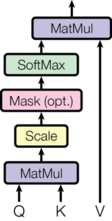

In [12]:
def attention(query, key, value, mask=None, dropout=None):
	d_k = query.size(-1)
	scores = torch.matmul(query, key.transpose(-2, -1)) \
		/ math.sqrt(d_k)
	if mask is not None:
		scores = scores.masked_fill(mask == 0, -1e9)
	p_attn = F.softmax(scores, dim = -1)
	if dropout is not None:
		p_attn = dropout(p_attn)
	return torch.matmul(p_attn, value), p_attn

我们使用一个实际的例子跟踪一些不同Tensor的shape，然后对照公式就很容易理解。

比如Q是(30,8,33,64)，其中30是batch，8是head个数，33是序列长度，64是每个时刻的特征数。K和Q的shape必须相同的，而V可以不同，但是这里的实现shape也是相同的。

In [ ]:
scores = torch.matmul(query, key.transpose(-2, -1)) \
	/ math.sqrt(d_k)

上面的代码实现$\frac{QK^T}{\sqrt{d_k}}$
，和公式里稍微不同的是，这里的Q和K都是4d的Tensor，包括batch和head维度。matmul会把query和key的最后两维进行矩阵乘法，这样效率更高，如果我们要用标准的矩阵(二维Tensor)乘法来实现，那么需要遍历batch维和head维：

输出的score是(30, 8, 33, 33)，前面两维不看，那么是一个(33, 33)的attention矩阵a，$a_{ij}$
表示时刻i attend to j的得分(还没有经过softmax变成概率)。

这里mask是(30, 1, 1, 33)的tensor，因为8个head的mask都是一样的，所有第二维是1，masked_fill时使用broadcasting就可以了。这里是self-attention的mask，所以每个时刻都可以attend到所有其它时刻，所有第三维也是1，也使用broadcasting。如果是普通的mask，那么mask的shape是(30, 1, 33, 33)。

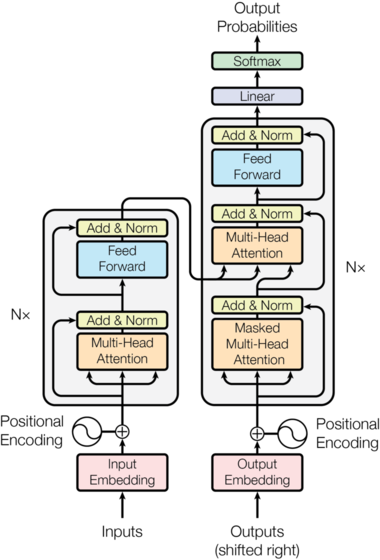

**输入信息怎么变成Q, K, V？**

对于每一个Head，都使用三个矩阵$W^Q$,$W^K$,$W^V$
把输入转换成Q，K和V。然后分别用每一个Head进行Self-Attention的计算，最后把N个Head的输出拼接起来，最后用一个矩阵$W^O$
把输出压缩一下。

比如：Head的数目是8，$d_k=d_v=d_{model}/h=64$

详细结构如下图所示：输入Q,K,V经过多个线性变换后得到N(8)组Query，Key和Value，然后使用Self-Attention计算得到N个向量，然后拼接起来，最后使用一个线性变换进行降维。
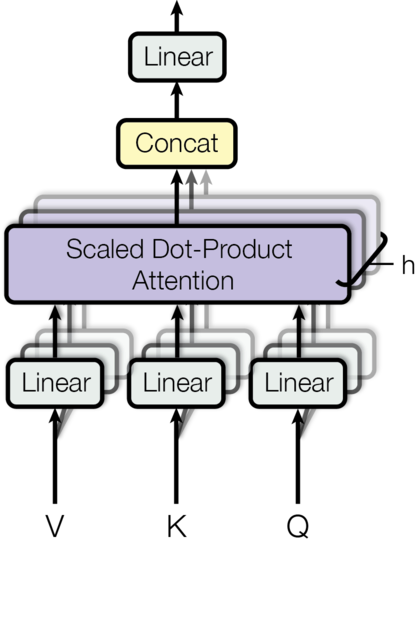

In [13]:
class MultiHeadedAttention(nn.Module):
	def __init__(self, h, d_model, dropout=0.1):
		super(MultiHeadedAttention, self).__init__()
		assert d_model % h == 0
		# We assume d_v always equals d_k
		self.d_k = d_model // h
		self.h = h
		self.linears = clones(nn.Linear(d_model, d_model), 4)
		self.attn = None
		self.dropout = nn.Dropout(p=dropout)
	
	def forward(self, query, key, value, mask=None): 
		if mask is not None:
			# 所有h个head的mask都是相同的 
			mask = mask.unsqueeze(1)
		nbatches = query.size(0)
		
		# 1) 首先使用线性变换，然后把d_model分配给h个Head，每个head为d_k=d_model/h 
		query, key, value = \
			[l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)	
				for l, x in zip(self.linears, (query, key, value))]
		
		# 2) 使用attention函数计算
		x, self.attn = attention(query, key, value, mask=mask, 
			dropout=self.dropout)
		
		# 3) 把8个head的64维向量拼接成一个512的向量。然后再使用一个线性变换(512,521)，shape不变。 
		x = x.transpose(1, 2).contiguous() \
			.view(nbatches, -1, self.h * self.d_k)
		return self.linears[-1](x)

In [14]:
d_model = 64
linears = clones(nn.Linear(d_model, d_model), 4)
linears
Q = torch.ones((32, 8, 31, 13)) # 32是batch的数目 8是head个数 31是序列长度 13是每个时刻下的特征向量长度

ModuleList(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=64, bias=True)
)

在transformer中，有3个地方用到了MultiHeadedAttention:
* Encoder的self-attention层：query, key和value都是相同的值，来自下层的输入。mask都是1
* Decoder的self-attention层：query, key和value都是相同的值，mask使它不能访问未来的输入
* Encoder-Decoder的普通attention：query来自下层的输入，而key和value相同，是Encoder最后一层的输出

http://fancyerii.github.io/2019/03/09/transformer-codes/

In [22]:
motion = torch.tensor([[[1, 3, 4], [2, 5, 6]]])
print(motion.shape)
mask = motion.resize(motion.size(0),motion.size(1))
print(mask.shape)

torch.Size([1, 2, 3])


RuntimeError: requested resize to 1x2 (2 elements in total), but the given tensor has a size of 1x2x3 (6 elements). autograd's resize can only change the shape of a given tensor, while preserving the number of elements. 

In [4]:
import numpy as np
feature_path = '/home/liumin/litianyi/workspace/data/datasets/features/0213_take_01/feature_10frames.npy'
feature = np.load(feature_path)
feature[0:30]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [12]:
sx = np.ones((1,6))
sx[0, 2]

1.0